In [7]:
import cv2,os,torch
import json
import matplotlib.pyplot as plt
import numpy as np
from load_data import load_data,load_data_detection
from torch.utils.data import Dataset,DataLoader
import albumentations as albu
import torchvision
import torch.nn as nn

In [19]:
!ls "./AI基线资料/灰色"


交界性	良性  全切组  恶性  正常组


In [34]:
# !ls "./AI基线资料/灰色"
# paths = []
# for i in ["正常组","全切组"]:
#     dirs = os.listdir("./AI基线资料/灰色/" + i)
#     dirs = [os.path.join("./AI基线资料/灰色/",i,d) for d in dirs]
#     paths = paths + dirs
# test = ['2021','2020']
# tenum,trnum = [],[]
# for p in paths:
#     is_test = False
#     for t in test:
#         if t in p:
#             is_test = True
#     if is_test:
#         tenum.append(p)
#     else:
#         trnum.append(p)
# tenumfig,trnumfig = 0,0
# def get_fig_num(paths):
#     x = 0
#     for p in paths:
#         p = os.listdir(p+"/Images")
#         p = [pp  for pp in p if ".jpg" in pp]
#         x += len(p)
#     return x
# get_fig_num(tenum),get_fig_num(trnum)

交界性	良性  全切组  恶性  正常组


(564, 1100)

In [11]:
def load_data_detector_one(path='./data',mode='train',verbose=False):
    imgs,masks,type_labels,pathology_labels = [],[],[],[]
    name = []
    
    for basepath,dirnames,files in os.walk(path):
        jpg = [f for f in files if '.jpg' in f]
        if len(jpg) == 0:
            continue
        for j in jpg:
            jpg_path = os.path.join(basepath,j)
            img = cv2.imread(jpg_path,0)
                
            na = basepath.replace("/Image","").split("/")[-1]
            imgs.append(img)
            type_labels.append("exist")
            pathology_labels.append(0)
            name.append(na)
                
    return imgs,type_labels,name
def load_data_detector_zero(path='./data',mode='train',verbose=False):
    imgs,masks,type_labels,pathology_labels = [],[],[],[]
    name = []
    
    for basepath,dirnames,files in os.walk(path):
        jpg = [f for f in files if '.jpg' in f]
        if len(jpg) == 0:
            continue
        for j in jpg:
            jpg_path = os.path.join(basepath,j)
            img = cv2.imread(jpg_path,0)
                
            na = basepath.replace("/Image","").split("/")[-1]
            imgs.append(img)
            type_labels.append("no")
            pathology_labels.append(0)
            name.append(na)
                
    return imgs,type_labels,name
def load_data_detection(path='./data',mode='train',verbose=False):
    types_dict = {'恶性':'exist', '良性':'exist', '交界性':'exist','全切组':'no','正常组':'no'}
    types = os.listdir(path)
    imgs,masks,type_labels,pathology_labels = [],[],[],[]
    name = []
    for i in types:
        dirnames = os.listdir(os.path.join(path,i))
        for d in dirnames:
            tmp_path = os.path.join(path,i,d,'Images')
            files = os.listdir(tmp_path)
            jpg = [f for f in files if '.jpg' in f]
            for j in jpg:
                jpg_path = os.path.join(tmp_path,j)
                img = cv2.imread(jpg_path,0)
                
                mask = np.zeros_like(img)
                if types_dict[i] == 'exist':
                    try:
                        js = json.load(open(jpg_path.replace('.jpg','.json'),'r'))
                    except:
                        print(jpg_path)
                    for shape in js['shapes']:
                        cv2.fillPoly(mask,[np.int32(shape['points'])],color=255)
                
                if verbose:
                    plt.figure(figsize=(10,5))
                    plt.subplot(1,2,1);plt.imshow(img,cmap='gray')
                    plt.subplot(1,2,2);plt.imshow(mask,cmap='gray')
                    plt.title(types_dict[i])
                    plt.show()
                
                imgs.append(img)
                masks.append(mask)
                type_labels.append(types_dict[i])
                pathology_labels.append(0)
                name.append(d)
    return imgs,masks,type_labels,pathology_labels,name

In [12]:
imgs,type_labels,name = load_data_detection(path='./AI基线资料/灰色/',verbose=False)
# imgs,type_labels,name = load_data_detection(path='./AI基线资料/灰色/',verbose=False)
# imgs,type_labels,name = load_data_detector_one(path='./外部测试图片/外部医院1/灰色/',verbose=False)
# imgs1,type_labels1,name1 = load_data_detector_zero(path='./外部测试图片/外部医院1/正常卵巢/',verbose=False)
# imgs,type_labels,name = load_data_detector_one(path='./外部测试图片/外部医院2/灰色/',verbose=False)
# imgs1,type_labels1,name1 = load_data_detector_zero(path='./外部测试图片/外部医院2/正常/',verbose=False)


FileNotFoundError: [Errno 2] No such file or directory: './AI基线资料/灰色/恶性/原发卵巢癌/Images'

In [4]:
imgs = imgs + imgs1
type_labels = type_labels + type_labels1
name = name + name1

In [5]:
test = ['2021','2020']
tr_imgs,tr_masks,tr_type_labels,tr_pathology_labels,tr_name = [],[],[],[],[]
te_imgs,te_masks,te_type_labels,te_pathology_labels,te_name = [],[],[],[],[]
sta_tr_exist = 0
sta_tr_no = 0
sta_te_exist = 0
sta_te_no = 0

for i in range(len(name)):
    istest = False
    for t in test:
        if f'.{t}' in name[i]:
            istest = True
    if istest or True:
        te_imgs.append(imgs[i])
        te_type_labels.append(type_labels[i])
        te_name.append(name[i])
        if type_labels[i] =='exist':
            sta_te_exist += 1
        else:
            sta_te_no += 1
        tr_imgs.append(imgs[i])
        tr_type_labels.append(type_labels[i])
        tr_name.append(name[i])
        if type_labels[i] =='exist':
            sta_tr_exist += 1
        else:
            sta_tr_no += 1
    else:
        tr_imgs.append(imgs[i])
        tr_type_labels.append(type_labels[i])
        tr_name.append(name[i])
        if type_labels[i] =='exist':
            sta_tr_exist += 1
        else:
            sta_tr_no += 1
print(sta_tr_exist,sta_tr_no,sta_te_exist,sta_te_no)

269 178 269 178


In [6]:
## combine
def extract_name(n):
    n = n.split('_')
    n1,n2 = n[0],n[1]
    n1 += '_'
    for n22 in n2:
        if not (n22.isdigit() or n22 in ['.','C'] ):
            n1 += n22
    return n1
train_case,test_case = {},{}

for i,n in enumerate(tr_name):
    try:
        n1 = extract_name(n)
    except:
        n1 = n
    if not train_case.__contains__(n1):
        train_case[n1] = tr_type_labels[i]
for i,n in enumerate(te_name):
    try:
        n1 = extract_name(n)
    except:
        n1 = n
    if not test_case.__contains__(n1):
        test_case[n1] = te_type_labels[i]
def statistic(case):
    sta = {}
    for key in case:
        gray = case[key]
        if not sta.__contains__(gray):
            sta[gray] = 1
        else:
            sta[gray] += 1
    print(sta)
    sta = {}
    for key in case:
        gray = case[key]
        if not sta.__contains__(gray):
            sta[gray] = len(case[key])
        else:
            sta[gray] += len(case[key])
statistic(train_case)
statistic(test_case)

{'exist': 99, 'no': 96}
{'exist': 99, 'no': 96}


In [29]:
class mydataset(Dataset):
    def __init__(self,imgs,types_labels,croptumour=False,mode='train'):
        self.imgs = imgs
        self.tlabels = types_labels
        self.type_dict = {'exist':0,'no':1}

        self.trans = albu.Compose([
            albu.OneOf([
                albu.Resize(height=240,width=320),
                albu.Compose([
                    albu.Resize(height=260,width=340),
                    albu.RandomCrop(height=240,width=320)
                ])
            ],p=1),
            albu.ShiftScaleRotate(p=0.5),
            albu.VerticalFlip(p=0.1),
            albu.HorizontalFlip(p=0.1),
        ])
        self.testtrans = albu.Compose([
            albu.Resize(height=240,width=320),
        ])
        self.mode = mode
        
    def __getitem__(self,index):
        img = self.imgs[index]
        
        if self.mode == 'test':
            trans = self.testtrans(image=img)
            img = trans['image']
        else:
            trans = self.trans(image=img)
            img = trans['image']
        
        tlabel = self.type_dict[self.tlabels[index]]
        
        img = torch.tensor(img/255).float().unsqueeze(0)
        tlabel = torch.tensor(tlabel).long()
        return img,tlabel
    def __len__(self):
        return len(self.imgs)

In [30]:
tr_dataset = mydataset(tr_imgs + te_imgs,tr_type_labels+te_type_labels,mode='train')
tr_dataloader = DataLoader(dataset=tr_dataset,batch_size=4,shuffle=True)
te_dataset = mydataset(te_imgs,te_type_labels,mode='test')
te_dataloader = DataLoader(dataset=te_dataset,batch_size=8,shuffle=False)

In [31]:
device='cuda:1'
model = torchvision.models.resnet18(pretrained=True)
# model.features[0]=nn.Conv2d(1,64,3,1,1)
# model.classifier[6]=nn.Linear(4096,3,bias=False)
model.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
model.fc = nn.Linear(512,2,bias=False)
model = torch.load('./weights/detection_gray_2cls_21.pth')
model = model.to(device)

In [32]:
cri = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay=3e-5)

In [33]:
def train(dl):
    epoch_loss = 0
    for i,(x,t) in enumerate(dl):
        x,t = x.to(device),t.to(device)
#         x = torch.cat([x,m.unsqueeze(1)*x],dim=1)
        p = model(x)
        
        loss = cri(p,t)
        epoch_loss += loss.item() / len(dl)
        
        opt.zero_grad();loss.backward();opt.step()
        
        print('\r{}/{},train_loss:{:.2f}'.format(i,len(dl),loss.item()),end='',flush=True)
    return epoch_loss
def test(dl):
    epoch_loss = 0
    
    preds,ys=[],[]
    model.eval()
    for i,(x,t) in enumerate(dl):
        x,t = x.to(device),t.to(device)
#         x = torch.cat([x,m.unsqueeze(1)*x],dim=1)
        with torch.no_grad():
            p = model(x)
            loss = cri(p,t)
            epoch_loss += loss.item() / len(dl)
            
            ys.append(t.detach().cpu())
            preds.append(p.detach().cpu())
        print('\r{}/{},test_loss:{:.2f}'.format(i,len(dl),loss.item()),end='',flush=True)
        
    ys = torch.cat(ys).numpy()
    preds = torch.cat(preds)
    preds = torch.softmax(preds,dim=1)
    argpreds = torch.argmax(preds,dim=1).numpy()
    
    correct = len(ys[ys==argpreds])
    acc = correct / len(ys)
    print('-----------------')
    print(correct,len(ys))
    return epoch_loss,{'acc':acc,'y':ys,'pred':preds.numpy()}

In [30]:
best_acc = 0
for e in range(200):
    train_loss = train(tr_dataloader)
    test_loss,metric = test(te_dataloader)
    print('-----------------')
    print('train_loss:{:.4f},test_loss:{:.4f}'.format(train_loss,test_loss))
    print('accuracy:{:.4f}'.format(metric['acc'])) 
    
    if best_acc < metric['acc']:
        best_acc = metric['acc']
        torch.save(model,'./weights/detection_gray_2cls_21.pth')
        print('==> saved model')

99/100,test_loss:0.6721-----------------
703 800
-----------------
train_loss:0.4512,test_loss:0.3010
accuracy:0.8788
==> saved model
99/100,test_loss:0.0837-----------------
687 800
-----------------
train_loss:0.2757,test_loss:0.3321
accuracy:0.8588
99/100,test_loss:0.1027-----------------
743 800
-----------------
train_loss:0.2177,test_loss:0.1844
accuracy:0.9287
==> saved model
99/100,test_loss:0.0300-----------------
701 800
-----------------
train_loss:0.2009,test_loss:0.2811
accuracy:0.8762
99/100,test_loss:0.0333-----------------
765 800
-----------------
train_loss:0.1757,test_loss:0.1440
accuracy:0.9563
==> saved model
99/100,test_loss:0.0507-----------------
768 800
-----------------
train_loss:0.1642,test_loss:0.1722
accuracy:0.9600
==> saved model
99/100,test_loss:0.2100-----------------
724 800
-----------------
train_loss:0.1489,test_loss:0.2002
accuracy:0.9050
99/100,test_loss:0.0101-----------------
772 800
-----------------
train_loss:0.1434,test_loss:0.0919
accuracy

KeyboardInterrupt: 

## plot

In [34]:
test_loss,metric = test(te_dataloader)

55/56,test_loss:6.52-----------------
271 447


In [9]:
0.9331,0.9748

(0.9331, 0.9748)

In [156]:
import sklearn
def statistic(y,p):
    argp = np.argmax(p,axis=1)
    uni = np.unique(y)
    acc = sklearn.metrics.accuracy_score(y,np.argmax(p,axis=1))
    matrix = sklearn.metrics.confusion_matrix(y, argp)
    for i in range(matrix.shape[0]):
        print(f'-------for cate {i}--------')
        TP,FP,TN,FN = 0,0,0,0
        for yy,pp in zip(y,argp):
            if yy == pp and yy == i:
                TP += 1
            if yy == pp and yy != i:
                TN += 1
            if yy != pp and yy == i:
                FN += 1
            if yy != pp and yy != i:
                FP += 1
        sensitivity = TP / (TP+FN)
        specifity = TP/(TP+FP)
        print('sensitivity:{:.4f},specifity:{:.4f}'.format(sensitivity,specifity))
        
        fpr1, tpr1, thresholds1 = metrics.roc_curve(y,p[:,1], pos_label=1)
        roc_auc1 = metrics.auc(fpr1, tpr1)  
        print('auc:{:.4f}'.format(roc_auc1))
statistic(metric['y'],metric['pred'])

-------for cate 0--------
sensitivity:0.9444,specifity:1.0000
auc:1.0000
-------for cate 1--------
sensitivity:1.0000,specifity:0.9912
auc:1.0000


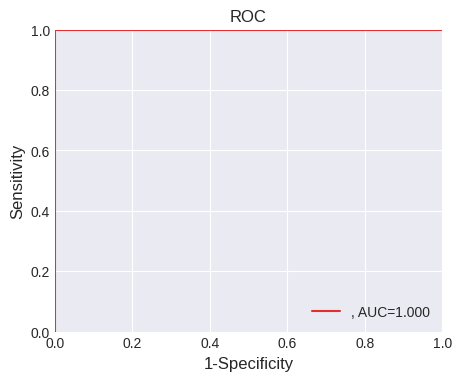

In [95]:

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
from sklearn import metrics
import matplotlib.pyplot as pyplot

styles=['fivethirtyeight',
 'dark_background',
 'bmh',
 'classic',
 'seaborn-dark',
 'grayscale',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-colorblind',
 'seaborn-white',
 'seaborn-dark-palette',
 'ggplot',
 'tableau-colorblind10',
 '_classic_test',
 'seaborn-darkgrid',
 'seaborn-notebook',
 'Solarize_Light2',
 'seaborn-paper',
 'seaborn-whitegrid',
 'seaborn-pastel',
 'seaborn-talk',
 'seaborn-bright',
 'seaborn',
 'seaborn-ticks',
 'seaborn-poster',
 'fast']
 
def rocs_plot(y2, P2, setname=''):
 
    pyplot.figure(figsize=(5, 4), dpi=100)
    pyplot.style.use('seaborn-darkgrid')
    
    palette = pyplot.get_cmap('Set1')
    
        
    for i, p2 in enumerate(P2):
        fpr1, tpr1, thresholds1 = metrics.roc_curve(y2,p2, pos_label=1)
        roc_auc1 = metrics.auc(fpr1, tpr1)   
        pyplot.plot(fpr1, tpr1, color=palette(i), linewidth=1.5, alpha=0.9, label=setname[i][:-10]+", AUC=%0.3f" % (roc_auc1))       
    pyplot.xlim([0.00, 1.0])
    pyplot.ylim([0.00, 1.0])
    pyplot.xlabel("1-Specificity",fontsize=12)
    pyplot.ylabel("Sensitivity",fontsize=12)
    pyplot.title("ROC",fontsize=12)
    pyplot.legend(loc="lower right")
#     pyplot.savefig('ROC.png',dpi=300)
    pyplot.show()
rocs_plot(metric['y'],[metric['pred']],setname=['detection'])

In [35]:
metric['pred']

'preds'